# Algorithm for segmentation and index extraction

## Image segmentation

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

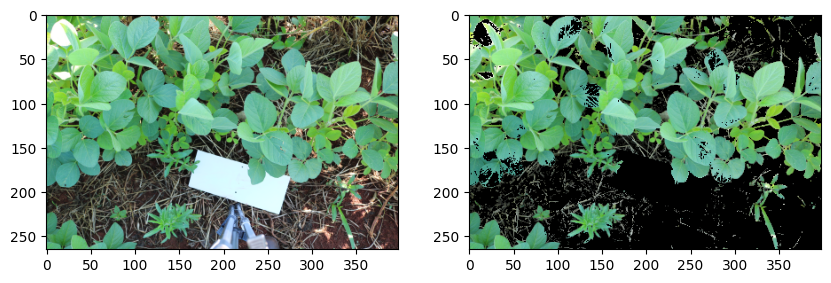

In [2]:
# Opening and displaying image

image = cv2.imread("./../ImagesandMap/2Amostragem/IMG_4117.JPG", cv2.IMREAD_COLOR)

scale_percent = 10 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# Resize image
resizedImage = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
RGB_image = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2RGB)

# Creating segmented image
hsv = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2HSV)

lower = np.array([35, 0, 0])
upper = np.array([85, 255, 255])

mask = cv2.inRange(hsv, lower, upper)

masked = cv2.bitwise_and(hsv, hsv, mask=mask)

newImage = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)

# Plot images
rows = 1
columns = 2
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(rows, columns, 1)

plt.imshow(RGB_image)

fig.add_subplot(rows, columns, 2)
plt.imshow(newImage)

## Extracting indexes and saving the values in a csv file

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pandas as pd

### Single image

In [4]:
def resizeAndSegment(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)

    scale_percent = 10 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    resizedImage = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    hsv = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2HSV)

    lower = np.array([35, 0, 0])
    upper = np.array([85, 255, 255])

    mask = cv2.inRange(hsv, lower, upper)

    masked = cv2.bitwise_and(hsv, hsv, mask=mask)

    newImage = cv2.cvtColor(masked, cv2.COLOR_HSV2RGB)
    return(newImage)

def generatingIndexes(image):
    B, G, R = cv2.split(image) 
    meanG = np.mean(G, axis=None) 
    meanR = np.mean(R, axis=None)
    meanB = np.mean(B, axis=None)

    # Normalizing values
    mean1G = meanG/255
    mean1R = meanR/255
    mean1B = meanB/255

    # Obtaining HSV values
    if max(meanG,meanR, meanB) == meanR:
        H = 60*((mean1G-mean1B)/(max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B)))  if (max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B)) != 0 else 0
    if max(meanG,meanR, meanB) == meanG:
        H = 60*(2+((mean1B-mean1R)/(max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B))))  if (max(mean1R,mean1G,mean1B)-min(mean1R,mean1G,mean1B)) != 0 else 0
    if max(meanG,meanR, meanB) == meanB:
            H = 60*(4+((mean1R-mean1G)/(max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B))))  if (max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B)) != 0 else 0
    S = (max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B))/max(mean1G,mean1R, mean1B)  if (max(mean1G,mean1R, mean1B)-min(mean1G,mean1R, mean1B)) != 0 else 0
    V = max(mean1G,mean1R, mean1B)

    # Calculating vegetative indices
    ICVE = ((H - 60)/60 + (1-S)+(1-V))/3
    ExG = (2*mean1G) - mean1R - mean1B
    NGRDI = (mean1G - mean1R) / (mean1G + mean1R)
    NGBDI = (mean1G - mean1B) / (mean1G + mean1B)
    RGBVI = (pow(mean1G,2) - (mean1B *pow(mean1R,2))) / (pow(mean1G,2) + (mean1B *pow(mean1R,2)))
    MGRVI = (pow(mean1G,2) - pow(mean1R,2)) / (pow(mean1G,2) + pow(mean1R,2))
    """ MPRI =(meanG - meanR)/(meanG + meanR) 
    Gn = (meanG)/(meanG + meanR + meanB) 
    Rn = (meanR)/(meanG + meanR + meanB) 
    Bn = (meanB)/(meanG + meanR + meanB) """
    
    res = [ICVE, ExG, NGRDI, NGBDI, RGBVI, MGRVI]
    return(res)

In [5]:
print(generatingIndexes(resizeAndSegment("./../ImagesandMap/4Amostragem/IMG_4402.JPG")))

[0.8506516129760149, 0.3434912260153895, 0.32867542248722664, 0.13669108289676057, 0.8338864647739729, 0.5932621935744788]


### All the folders

#### Image segmented

In [6]:
# Creating the empty array
indices = []

# Creating loop to enter in each folder
for root, dirs, files in os.walk("./../ImagesandMap/"):
    for name in files:
        if name.endswith('.JPG'):
            path = os.path.join(root, name)
            indexes = generatingIndexes(resizeAndSegment(str(path)))
            print(indexes)
            indices.append(indexes)

# Creating the database
df = pd.DataFrame(indices, columns = ['ICVE', 'ExG', 'NGRDI', 'NGBDI', 'RGBVI', 'MGRVI'])
df.index = df.index + 1

# Saving as csv file
cvs_file = df.to_csv("VisibleIndices.csv")

[0.8845075747547223, 0.09813045992076552, 0.21676398356622778, 0.17611184413360395, 0.9167461568752701, 0.4140721160691862]
[0.9053997685062151, 0.1479237103014146, 0.29833021598201814, 0.16810964333110417, 0.9209182895438696, 0.5478970882660132]
[0.9682111844864619, 0.12827678905069181, 0.3578787402157621, 0.11575317446977336, 0.9399647195446499, 0.6344933529942166]
[0.9559722791858037, 0.14741260873364234, 0.3603745674950257, 0.11988625009219647, 0.9334363663794923, 0.6379045767542226]
[0.9333723571257626, 0.18604405676179628, 0.34538830702190093, 0.12529167947614478, 0.9111161896134486, 0.6171543671316689]
[0.9854722934703375, 0.08539058593002008, 0.3298690343316062, 0.11841859649007906, 0.9528485589218585, 0.5949945785979153]
[0.9813715284127583, 0.0976062703454379, 0.347457493112635, 0.11677471588224025, 0.9512652991128819, 0.6200574862027025]
[0.9546205058793573, 0.05022957926889347, 0.21011315106119863, 0.1392565760139885, 0.9468030104047667, 0.40245874029648515]
[0.894076800821